In [13]:
import sys
sys.path.append("../src")

In [14]:
from ds.models import THGStrainStressCNN
import collections
from types import SimpleNamespace
import numpy as np
import torch
from torch.nn import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

from captum.attr import Occlusion, IntegratedGradients
from captum.attr import visualization as viz

from torchvision.transforms import Compose, Grayscale, ToTensor
from PIL import Image

import os

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
class NestedNamespace(SimpleNamespace):
    """Sot that the stub config dictionary can be accessed by the model
    as if it was the hydra config file.
    """
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

In [17]:
model_path = "/scistor/guest/sjg203/projects/shg-strain-stress/outputs/2022-11-07/18-46-29/checkpoint.pt"
img_path = "/scistor/guest/sjg203/projects/shg-strain-stress/data/z-stacks/6/0.bmp"
targets = torch.tensor([11.907111719516847, 23.35818343488239, 1.3435359224399381]).unsqueeze(0)

In [18]:
cfg = {
    "params": {
        "model": {
            "n_nodes": 64,
            "num_output_features": 3
        }
}}
cfg = NestedNamespace(cfg)

In [19]:
model = THGStrainStressCNN(cfg)
checkpoint = torch.load(model_path)
new_state_dict = collections.OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace("module.", '') # remove 'module.' prefix, because of bug in checkpoint saving.
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model = model.eval()
model.to(device)


THGStrainStressCNN(
  (network): Sequential(
    (0): Conv2d(1, 1, kernel_size=(53, 53), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 1, kernel_size=(53, 53), stride=(1, 1), bias=False)
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(1, 1, kernel_size=(53, 53), stride=(1, 1), bias=False)
    (7): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(1, 1, kernel_size=(53, 53), stride=(1, 1), bias=False)
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(1, 1, kernel_size=(53, 53), stride=(1, 1), bias=False)
    (13): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(1, 1, kernel_size=(53, 53), stride=(1, 1), bias=False)
   

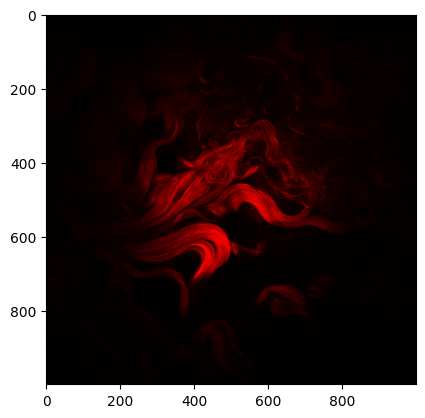

In [20]:
test_img = Image.open(img_path)
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [21]:
# model expects 1000x1000 1-color image
transform = Compose([
    Grayscale(),
    ToTensor()
])

transformed_img = transform(test_img)
input_img = transformed_img.unsqueeze(0) # the model requires a dummy batch dimension

In [22]:
input_img = input_img.to(device)

In [23]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
# Our targets look like (a, k, xc). With target=0, attributions to a are calculated.
# internal_batch_size is needed to not run OOM.
attributions_ig_a = integrated_gradients.attribute(input_img, target=0, n_steps=200, internal_batch_size=50)
attributions_ig_k = integrated_gradients.attribute(input_img, target=1, n_steps=200, internal_batch_size=50)
attributions_ig_xc = integrated_gradients.attribute(input_img, target=2, n_steps=200, internal_batch_size=50)

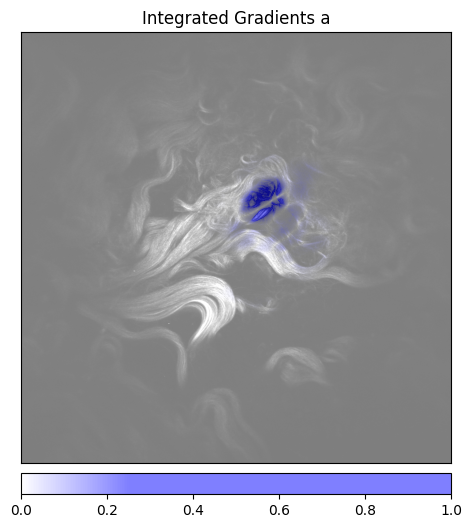

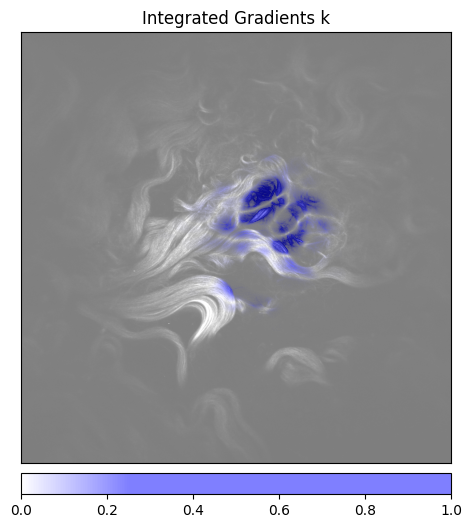

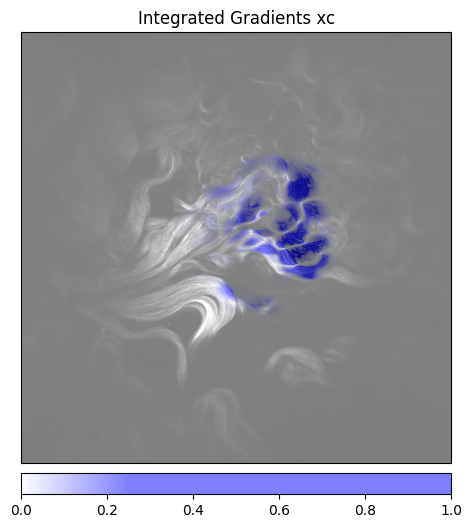

In [147]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

# Use the squeeze unsqueeze trick to make the images HWC which can be used by the function.
fig_a, axis_a = viz.visualize_image_attr(attributions_ig_a.squeeze().unsqueeze(2).cpu().detach().numpy(),
                             transformed_img.squeeze().unsqueeze(2).cpu().detach().numpy(),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                            #  sign='negative',
                             title='Integrated Gradients a')
fig_k, axis_k = viz.visualize_image_attr(attributions_ig_k.squeeze().unsqueeze(2).cpu().detach().numpy(),
                             transformed_img.squeeze().unsqueeze(2).cpu().detach().numpy(),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                            #  sign='negative',
                             title='Integrated Gradients k')
fig_xc, axis_xc = viz.visualize_image_attr(attributions_ig_xc.squeeze().unsqueeze(2).cpu().detach().numpy(),
                             transformed_img.squeeze().unsqueeze(2).cpu().detach().numpy(),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                            #  sign='negative',
                             title='Integrated Gradients xc')